<a href="https://colab.research.google.com/github/MoeedthePessimist/transcriptionClassification/blob/master/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [60]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

importing libraries

In [66]:
import spacy 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import string 
import re 
import gc 


from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

creating a list of null value identifiers

In [10]:
missing_value = ["N/a", "na", np.nan]

loading dataset

In [51]:
df = pd.read_csv('sample_data/test.csv', na_values = missing_value)

checking dataset

In [25]:
df.head()

,Sickness,Specialist
0,Flu Infection,Allergy Specialist
1,Timing Problem,Urologist
2,C Section Stitches Problem,Gynecologist
3,Menstrual Cycle,Gynecologist
4,Upper Lips Per Dark Hair,Gynecologist


checking no of rows in the dataset

In [26]:
df.shape[0]

5633

checking no of null values in each column

In [27]:
df.isnull().sum()

Sickness        0
Specialist    138
dtype: int64

plotting the null values in a heatmap

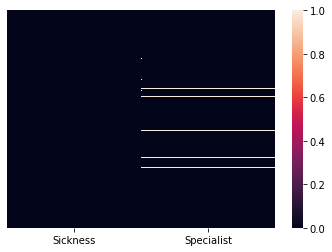

In [28]:
sns.heatmap(df.isnull(), yticklabels = False)

Another method rather than dropping the empty rows we fill the empty column with the previous or next value also known as forward/backward fill. but we wont be doing that instead we will be removing all the null column rows


In [30]:
df.fillna(method="ffill") #forward fill
df.fillna(method="bfill") #backward fill
df.shape[0]

5633

removing all the null rows

In [52]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None)
df.shape[0]

5495

checking if all the rows with a null column was dropped

In [38]:
df.isnull().sum()

Sickness      0
Specialist    0
dtype: int64

# Counts the number of words and sentences in a list of text

In [39]:
def count_sentence_word(text_list):
  sent_count = 0
  word_count = 0 
  vocab = {}
  for text in tqdm_notebook(text_list):
    sentences = sent_tokenize(str(text).lower())
    sent_count = sent_count + len(sentences)
    for sentence in sentences:
      words = word_tokenize(sentence)
      for word in words:
        if (word in vocab.keys()):
          vocab[word] = vocab[word] + 1
        else:
          vocab[word] = 1
  
  word_count = len(vocab.keys())
  return sent_count, word_count

# Counting the no of speciality occurences

In [40]:
df['Specialist'].value_counts()

Gynecologist              1626
General Physician          750
Dermatologist              646
Gastroenterologist         345
Urologist                  340
                          ... 
Heart - Cardiology           2
Pediatric Surgeon            1
Hijama Specialist            1
Cardiac Surgeon              1
 Premature Ejaculation       1
Name: Specialist, Length: 75, dtype: int64

#Check for missing values 

In [41]:
df.isnull().any()

Sickness      False
Specialist    False
dtype: bool

# Getting the number of words and sentences using the premade function from the sickness column

In [42]:
sent_count, word_count = count_sentence_word(df['Sickness'].to_list())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/5495 [00:00<?, ?it/s]

##Checking the number of words and sentences


In [45]:
sent_count

5564

# Data before filtering the specialities more than 100 occurences

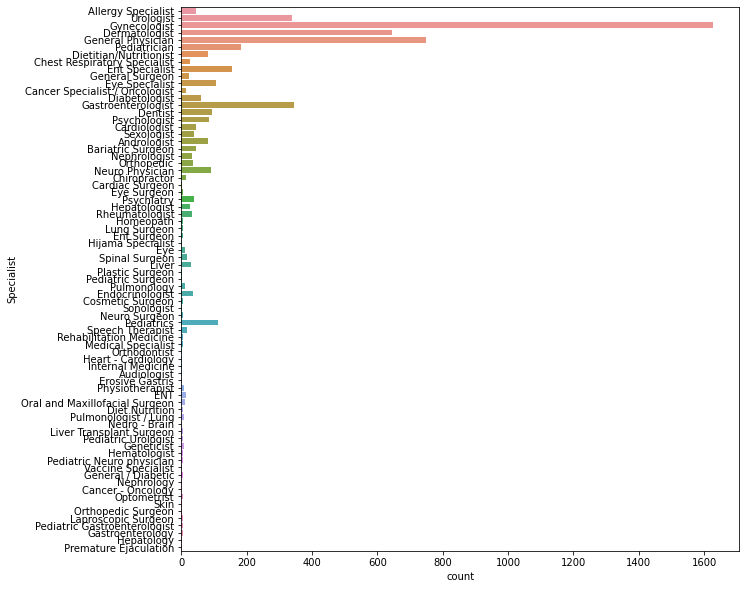

In [53]:
plt.figure(figsize=(10,10))
sns.countplot(y='Specialist', data=df)
plt.show()

##filtering the dataset to only contain specialities with occurence of 100 and more

In [54]:
df = df.groupby('Specialist').filter(lambda x: len(x) >= 100)
df.head()

,Sickness,Specialist
1,Timing Problem,Urologist
2,C Section Stitches Problem,Gynecologist
3,Menstrual Cycle,Gynecologist
4,Upper Lips Per Dark Hair,Gynecologist
5,Hair Loss,Dermatologist


###checking the filtered data length

In [55]:
df['Specialist'].value_counts()

Gynecologist          1626
General Physician      750
Dermatologist          646
Gastroenterologist     345
Urologist              340
Pediatrician           184
Ent Specialist         156
Pediatrics             114
Eye Specialist         106
Name: Specialist, dtype: int64

#Plotting the specialist data

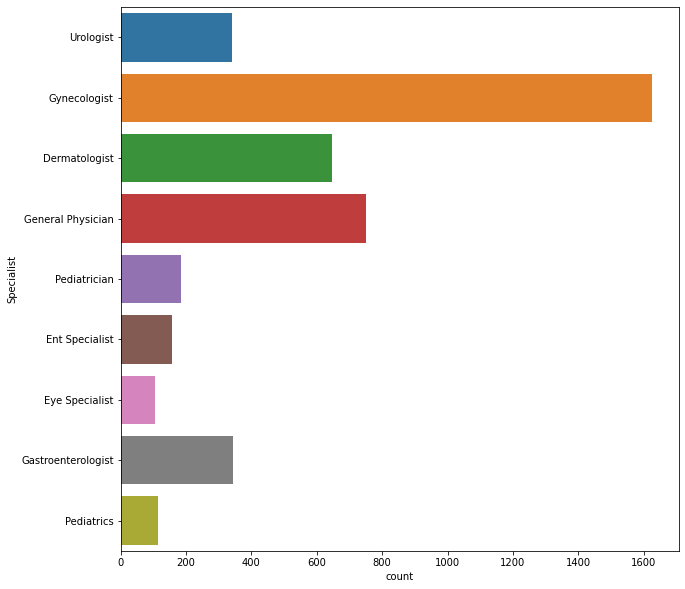

In [56]:
plt.figure(figsize=(10,10))
sns.countplot(y='Specialist', data=df)
plt.show()

#Creating functions to filter out any junk characters such as numbers or special characters

In [57]:
def clean_text(text): 

  text = text.translate(str.maketrans('', '', string.punctuation))
  text1 = ''.join([w for w in text if not w.isdigit()]) 
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
  
  text2 = text1.lower()
  text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
  #text2 = BAD_SYMBOLS_RE.sub('', text2)
  return text2

###Testing the clean_text Funciton

In [58]:
t = "Hello my name is #$% and my A-number is 1234432!!!"
t2 = clean_text(t)
t2

'hello my name is  and my anumber is '

#lemmatizer function to group related words

In [59]:
def lemmatizer(text):
  wordlist=[]
  lemmatizer = WordNetLemmatizer() 
  sentences=sent_tokenize(text)
    
  intial_sentences= sentences[0:1]
  final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
  for sentence in intial_sentences:
      words=word_tokenize(sentence)
      for word in words:
          wordlist.append(lemmatizer.lemmatize(word))
  for sentence in final_sentences:
      words=word_tokenize(sentence)
      for word in words:
          wordlist.append(lemmatizer.lemmatize(word))       
  return ' '.join(wordlist)

#Using lemmatizer and clean function to clean the text

In [61]:
df['Sickness'] = df['Sickness'].apply(lemmatizer)
df['Sickness'] = df['Sickness'].apply(clean_text)

###TF-IDF matrix: tf–idf (also TF*IDF, TFIDF, TF–IDF, or Tf–idf), short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [63]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1,3), max_df=0.75, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(df['Sickness'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)


['aa', 'aana', 'ab', 'abdomen', 'abdominal', 'abdominal pain', 'abnormal', 'abortion', 'acid', 'acidity', 'acne', 'acne acne', 'acne acne scars', 'acne dark', 'acne itching', 'acne problem', 'acne scars', 'advice', 'age', 'ago', 'aik', 'alikum', 'alikum dear', 'alikum dear doctor', 'allergy', 'alt', 'ami', 'ami ko', 'ami ko pity', 'ana', 'anal', 'analysis', 'analysis report', 'anemia', 'aoa', 'ap', 'appetite', 'area', 'arm', 'armpit', 'arms', 'asalam', 'asalam alikum', 'asalam alikum dear', 'ask', 'asking', 'assalamualaikum', 'assalamualaikum sir', 'asslam', 'asslam alikum', 'asslam alikum dear', 'atay', 'atay hain', 'atay hain bohat', 'ati', 'aur', 'aur bachani', 'baar', 'baby', 'baby girl', 'bachani', 'bad', 'baldness', 'bar', 'bara', 'bata', 'beard', 'beard growth', 'beat', 'belly', 'belly button', 'best', 'beta', 'beta hcg', 'beti', 'bhi', 'bhot', 'bht', 'birth', 'birth control', 'black', 'bladder', 'bleeding', 'blisters', 'block', 'blood', 'blood pressure', 'blood stool', 'blood t

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [98]:
print(tfIdfMat)

  (0, 736)	1.0
  (1, 872)	0.6897708342725869
  (1, 814)	0.640571091789586
  (1, 736)	0.3374683282182153
  (2, 175)	0.7137913442671225
  (2, 559)	0.7003584202744577
  (3, 331)	0.4311930013482957
  (3, 187)	0.5912121936871934
  (3, 526)	0.6815722541475886
  (4, 334)	0.6527560650236465
  (4, 538)	0.6046383662793288
  (4, 331)	0.4564230116875237
  (6, 900)	0.5412673309535181
  (6, 88)	0.5412673309535181
  (6, 783)	0.3551004718077942
  (6, 899)	0.38680235484625813
  (6, 85)	0.3719501930261374
  (8, 641)	1.0
  (9, 90)	0.5994979167902056
  (9, 657)	0.3164766436406937
  (9, 89)	0.5036852375826267
  (9, 819)	0.5354866601844138
  (10, 153)	1.0
  (11, 318)	1.0
  (12, 867)	0.6807188086903012
  :	:
  (4258, 422)	0.22634816774638775
  (4258, 458)	0.21106836236290574
  (4258, 63)	0.2177430276068366
  (4258, 450)	0.15462237445471233
  (4258, 560)	0.19033495838253486
  (4258, 612)	0.191869242332391
  (4258, 328)	0.6470148800239137
  (4258, 996)	0.184881359785646
  (4258, 18)	0.20322052796672022
  (4258

In [68]:
tfIdfMat.shape

(4267, 1000)

In [69]:
len(feature_names)

1000

In [71]:
df

,Sickness,Specialist
1,timing problem,Urologist
2,c section stitches problem,Gynecologist
3,menstrual cycle,Gynecologist
4,upper lips per dark hair,Gynecologist
5,hair loss,Dermatologist
...,...,...
5627,weakness due to tonsil,Ent Specialist
5629,stomach,Gastroenterologist
5630,uterine fibroid embolization uterine artery e...,Gynecologist
5631,ear problem for months,Ent Specialist


In [79]:
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = df['Specialist'].tolist()
tsne_results = TSNE(n_components=2, init='random', random_state=0, perplexity=40).fit_transform(tfIdfMatrix)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


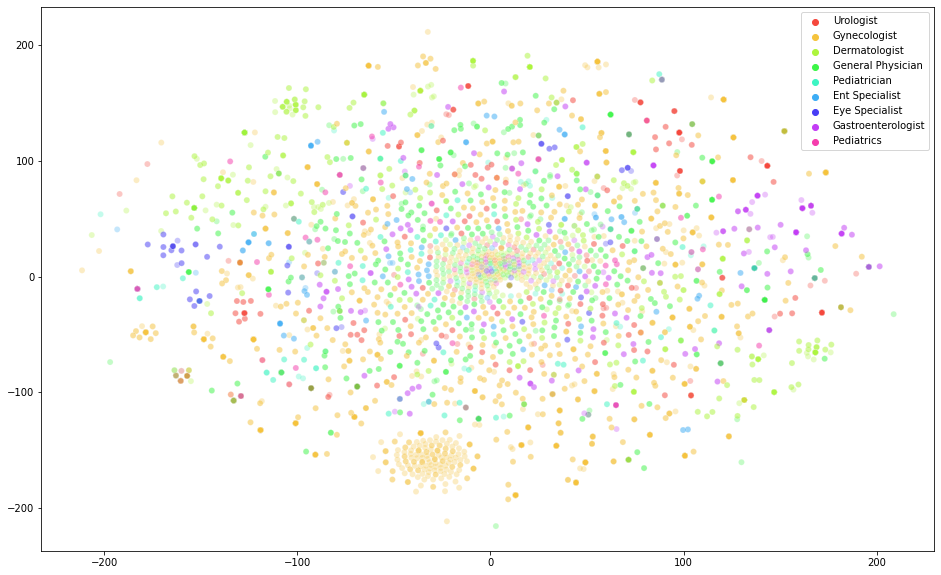

In [81]:
plt.figure(figsize=(16,10))
palette = sns.hls_palette(9, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [82]:
len(tsne_results)

4267

In [83]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = df['Specialist'].tolist()
category_list = df.Specialist.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels, random_state=1)

In [84]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3200, 538)
Test_Set_Size:(1067, 538)


In [85]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

In [86]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

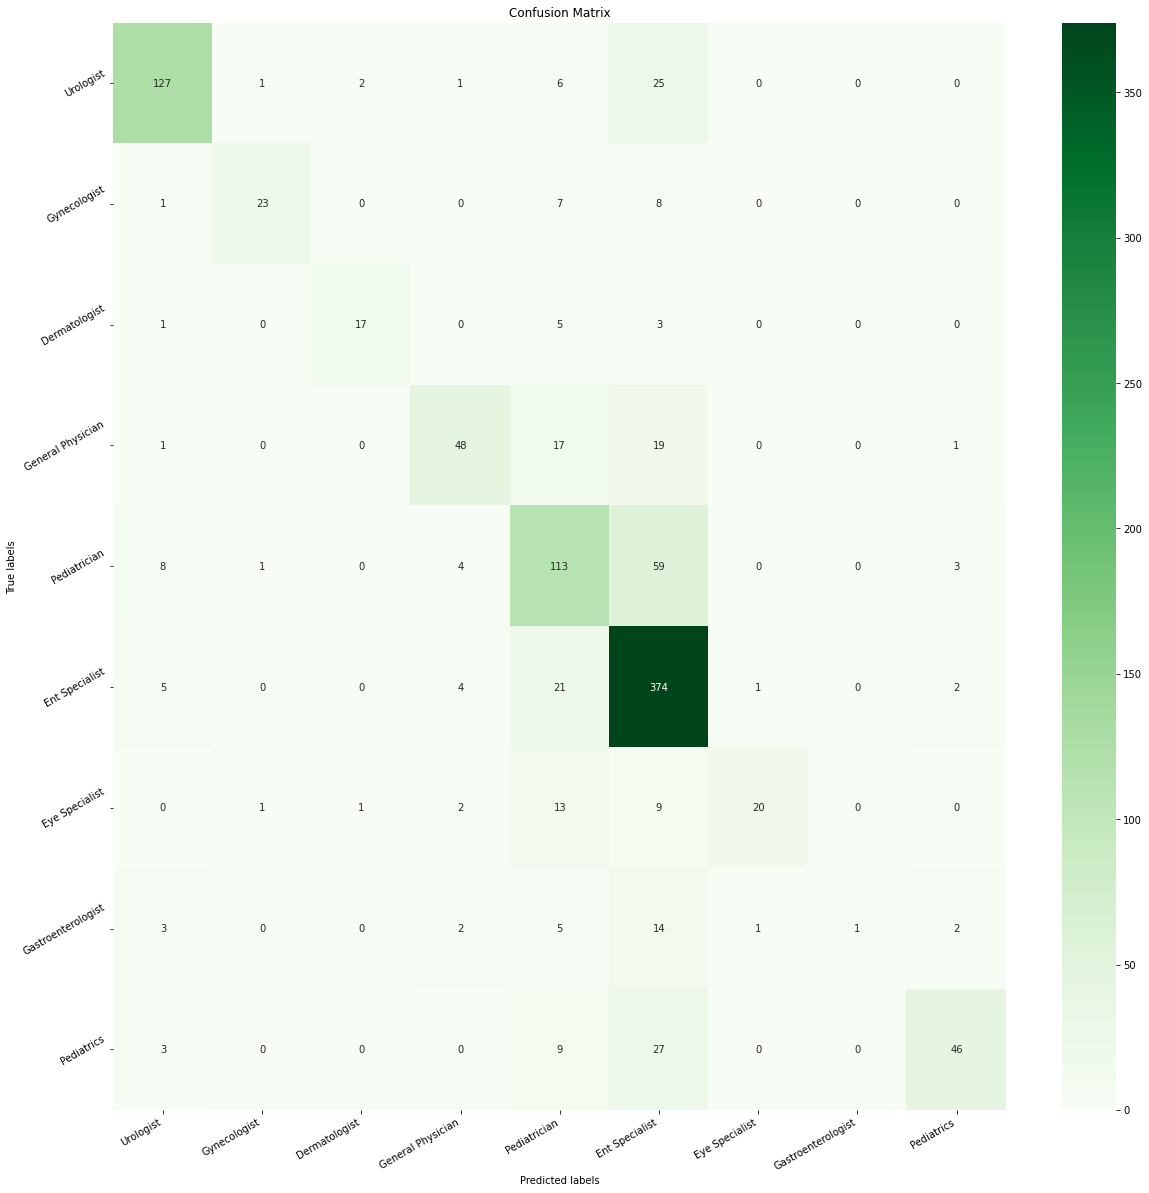

In [87]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [88]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                    precision    recall  f1-score   support

         Urologist       0.85      0.54      0.66        85
      Gynecologist       0.70      0.92      0.79       407
     Dermatologist       0.85      0.78      0.82       162
 General Physician       0.58      0.60      0.59       188
      Pediatrician       0.91      0.43      0.59        46
    Ent Specialist       0.88      0.59      0.71        39
    Eye Specialist       0.85      0.65      0.74        26
Gastroenterologist       0.79      0.56      0.65        86
        Pediatrics       1.00      0.04      0.07        28

          accuracy                           0.72      1067
         macro avg       0.82      0.57      0.62      1067
      weighted avg       0.75      0.72      0.71      1067



# ***NORMALIZING THE DATASET USING SMOTE***

In [89]:
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = df['Specialist'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(4340, 538)
Test_Set_Size:(1447, 538)


In [90]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)


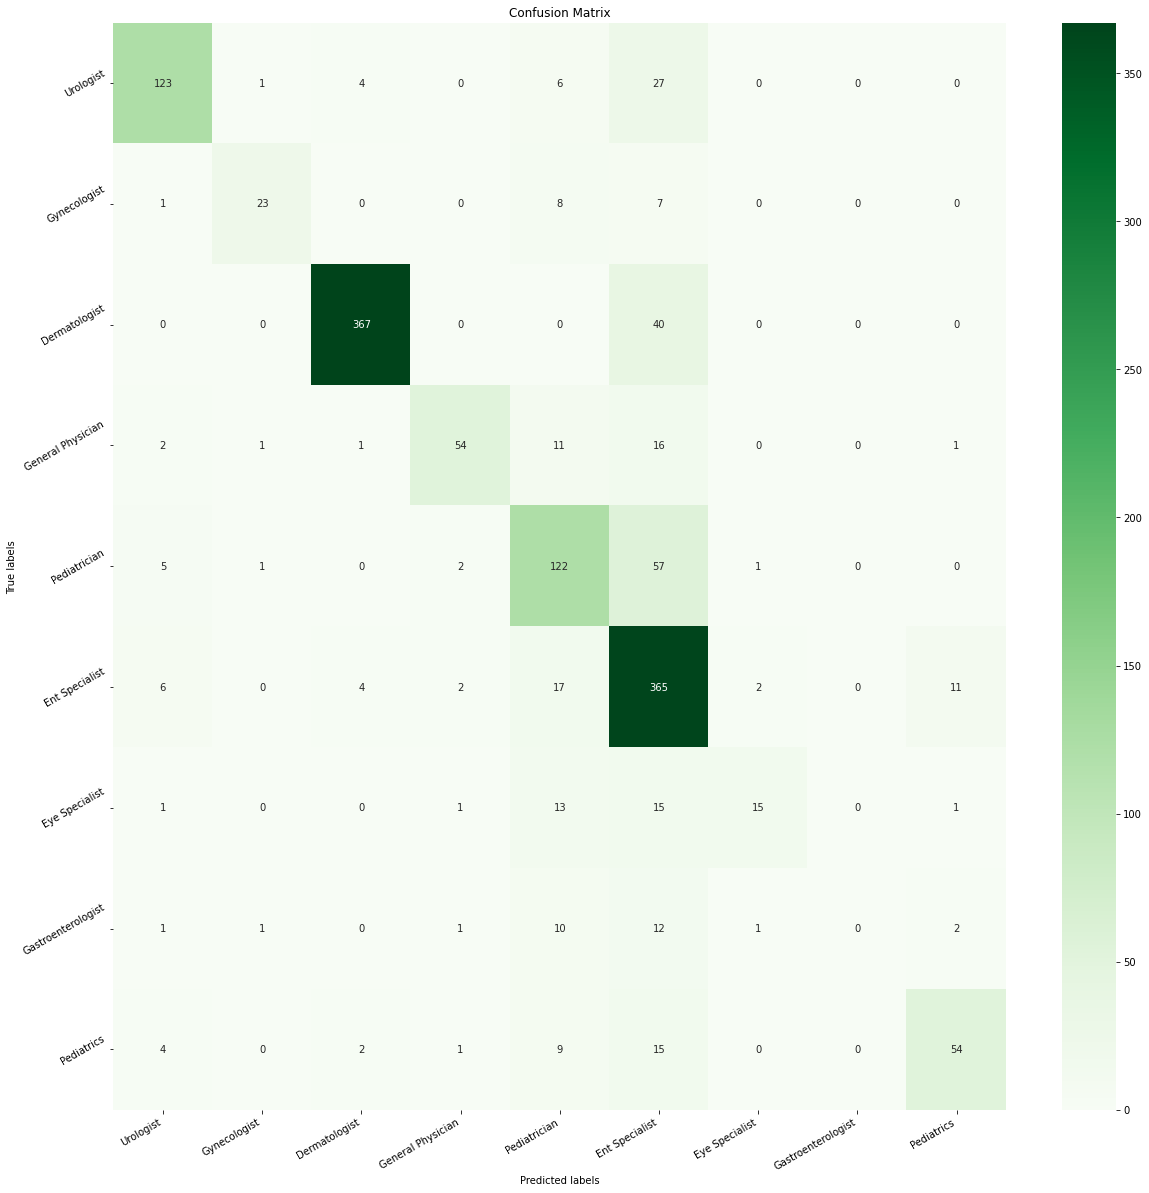

                    precision    recall  f1-score   support

         Urologist       0.78      0.64      0.70        85
      Gynecologist       0.66      0.90      0.76       407
     Dermatologist       0.86      0.76      0.81       161
 General Physician       0.62      0.65      0.64       188
      Pediatrician       0.79      0.33      0.46        46
    Ent Specialist       0.85      0.59      0.70        39
    Eye Specialist       0.97      0.90      0.94       407
Gastroenterologist       0.89      0.63      0.73        86
        Pediatrics       0.00      0.00      0.00        28

          accuracy                           0.78      1447
         macro avg       0.71      0.60      0.64      1447
      weighted avg       0.78      0.78      0.77      1447



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))